# 🍍 LibriBrain Competition: Advanced (Phoneme Classification)
Welcome! This Colab is the starting point for the second track of the LibriBrain competition hosted by the [PNPL](https://ori.ox.ac.uk/labs/pnpl/) at NeurIPS 2025. For a more basic introduction, you might prefer to take a look at the [Speech Detection variant](https://neural-processing-lab.github.io/2025-libribrain-competition/links/speech-colab) first, which includes a more comprehensive introduction and a slightly simpler task.

The following notebook will walk you through
1. setting up all necessary dependencies,
2. downloading training data, and
3. training a minimal model

It is fully functional in the Colab Free Tier, though training will of course be faster with more GPU horsepower. With default settings on a `T4` instance, the main training run should take no more than 45 minutes. If you want to speed up model training, make sure you are on a GPU runtime by clicking Runtime -> Change runtime type. TPU acceleration is currently not supported.

In case of any questions or problems, please get in touch through [our Discord server](https://neural-processing-lab.github.io/2025-libribrain-competition/links/discord).

⚠️ **Note**: We have only comprehensively validated the notebook to work on Colab and Unix. Your experience in other environments (e.g., Windows) may vary.

## Setting up dependencies
Run the code below *as is*. It will download all required dependencies, including our own [PNPL](https://pypi.org/project/pnpl/) package. On Windows, you might have to restart your Kernel after the installation has finished.

In [ ]:
# Install additional dependencies
%pip install -q mne_bids lightning torchmetrics scikit-learn plotly ipywidgets pnpl

# Set up base path for dataset and related files (base_path is assumed to be set in the cells below!)
base_path = "./libribrain"
try:
    import google.colab  # This module is only available in Colab.
    in_colab = True
    base_path = "/content"  # This is the folder displayed in the Colab sidebar
except ImportError:
    in_colab = False

## Preparing the dataset
The code below will automatically download the training data. For our reference model, we'll only use Sherlock1 sessions 1-11 as training data. For your implementation, you may want to set `partition="train"` instead of manually providing run keys. This will automatically load all available training data (Sherlock Books 1-7) - an order of magnitude more data.

In [ ]:
from pnpl.datasets import LibriBrainPhoneme
from torch.utils.data import DataLoader


train_dataset = LibriBrainPhoneme(
  data_path=f"{base_path}/data/",
  include_run_keys = [("0",str(i),"Sherlock1","1") for i in range(1, 10)],
  tmin=0.0,
  tmax = 0.5
  )


val_dataset = LibriBrainPhoneme(
  data_path=f"{base_path}/data/",
  partition="validation",  # this is equal to `include_run_keys = [("0",11,"Sherlock1","1")]`
  tmin=0.0,
  tmax = 0.5
)


test_dataset = LibriBrainPhoneme(
  data_path=f"{base_path}/data/", # this is equal to `include_run_keys = [("0",12,"Sherlock1","1")]
  partition="test",
  tmin=0.0,
  tmax = 0.5
)


The minimal example above is completely sufficient for you to get started. If you want to play around, here are all the options you _could_ set:
- `data_path`: Path where you wish to store the dataset. The local dataset structure will follow the same BIDS-like structure as the HuggingFace repo:
- `partition`: Convenient shortcut to specify train/validation/test split. Options: "train", "validation", "test"
- `label_type`: Type of labels to return. Options: "phoneme" (e.g., 'aa', 'ae', 'ah', etc.) or "voicing": Return voicing labels derived from phonemes indicating voiced. See https://en.wikipedia.org/wiki/Voice_(phonetics)
- `preprocessing_str`: By default, we expect files with preprocessing string "bads+headpos+sss+notch+bp+ds". This indicates the preprocessing we have done (check Speech Detection tutorial for details)
- `tmin`: Start time of the sample in seconds relative to phoneme onset. For a phoneme at time T, you grab MEG data from T + tmin up to T + tmax. Default: 0.0
- `tmax`: End time of the sample in seconds relative to phoneme onset. The number of timepoints per sample = int((tmax - tmin) * sfreq) where sfreq=250Hz. Default: 0.5 (this means each segment is made up of 125 samples)
- `include_run_keys`: List of specific sessions to include. Format per session: ('0', '1', 'Sherlock1', '1') = Subject 0, Session 1, Task Sherlock1, Run 1.
- `exclude_run_keys`: List of sessions to exclude (same format as include_run_keys).
- `exclude_tasks`: List of task names to exclude (e.g., ['Sherlock1']).
- `standardize`: Whether to z-score normalize each channel's MEG data using mean and std computed across all included runs. Default: True
- `clipping_boundary`: If specified, clips all MEG values to [-clipping_boundary, clipping_boundary]. Default: 10
- `channel_means` and `channel_stds`: Pre-computed channel means and stds for standardization. If provided, these will be used instead of computing from the dataset.
- `include_info`: Whether to include additional info dict in each sample containing dataset name, subject, session, task, run, onset time, and full phoneme label (including word position indicators). Default: False
- `preload_files`: Whether to "eagerly" download all dataset files from HuggingFace when the dataset object is created (True; default) or "lazily" download files on demand (False).
- `download`: Whether to download files from HuggingFace if not found locally (True; default) or throw an error if files are missing locally (False).

## The task: Phoneme Classification
Before we go any further, let's make sure we understand what we're actually trying to accomplish. In contrast to the earlier Speech Detection task, where we just tried to figure out if our participant was listening to speech or not (binary classification), we're now trying to figure out which sounds (= [phonemes](https://en.wikipedia.org/wiki/Phoneme)) they were listening to. Specifically,
- each sample loaded by `LibriBrainPhoneme` corresponds to a "phoneme event" (i.e., a phoneme being heard), and
- each label/prediction corresponds to one of 39 phonemes (we used the ARPAbet phonemes classification http://speech.cs.cmu.edu/cgi-bin/cmudict)

In [28]:
train_dataset[0]

[tensor([[ 2.2000e-02,  3.7515e-02,  5.3006e-02,  ...,  1.3464e-05,
           1.4929e-02,  2.3485e-02],
         [-9.6447e-03, -2.6644e-02, -3.1221e-02,  ..., -1.6135e-02,
          -3.1057e-02, -1.4162e-02],
         [-1.9342e-01, -1.8922e-01, -1.4542e-01,  ..., -1.8494e-01,
          -8.4027e-02,  3.9054e-02],
         ...,
         [-4.4214e-02,  1.2642e-02,  5.9227e-03,  ..., -1.0573e-01,
          -3.2139e-02, -4.1115e-02],
         [ 2.6323e-02,  1.8204e-02,  1.7639e-02,  ...,  2.8929e-02,
           2.5494e-02,  2.9815e-02],
         [ 8.8393e-02, -6.1054e-03,  1.5763e-01,  ...,  1.3287e-01,
           6.6813e-02,  1.1044e-01]]),
 tensor(2)]

In [30]:
train_dataset.labels_sorted

['aa',
 'ae',
 'ah',
 'ao',
 'aw',
 'ay',
 'b',
 'ch',
 'd',
 'dh',
 'eh',
 'er',
 'ey',
 'f',
 'g',
 'hh',
 'ih',
 'iy',
 'jh',
 'k',
 'l',
 'm',
 'n',
 'ng',
 'ow',
 'oy',
 'p',
 'r',
 's',
 'sh',
 't',
 'th',
 'uh',
 'uw',
 'v',
 'w',
 'y',
 'z',
 'zh']

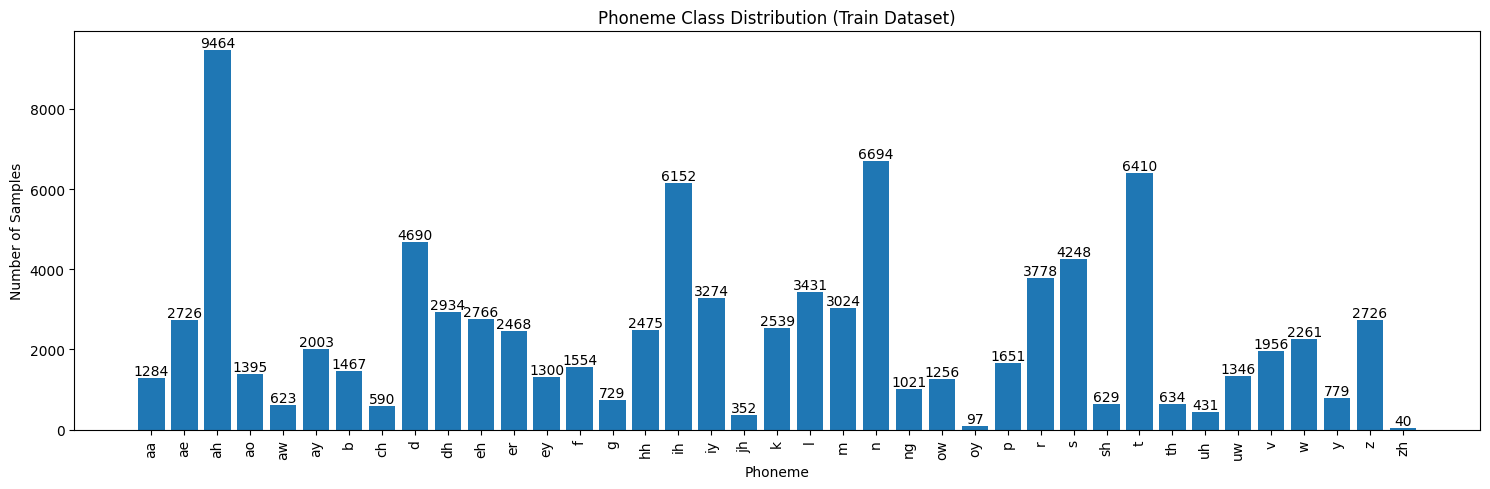

In [44]:
# Train Dataset
import matplotlib.pyplot as plt
import torch

label_counts = torch.zeros(len(train_dataset.labels_sorted))

for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    label_counts[label] += 1

plt.figure(figsize=(15, 5))
bars = plt.bar(train_dataset.labels_sorted, label_counts.numpy())
plt.xticks(rotation=90)
plt.title("Phoneme Class Distribution (Train Dataset)")
plt.xlabel("Phoneme")
plt.ylabel("Number of Samples")

# Add the counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment


plt.tight_layout()
plt.show()

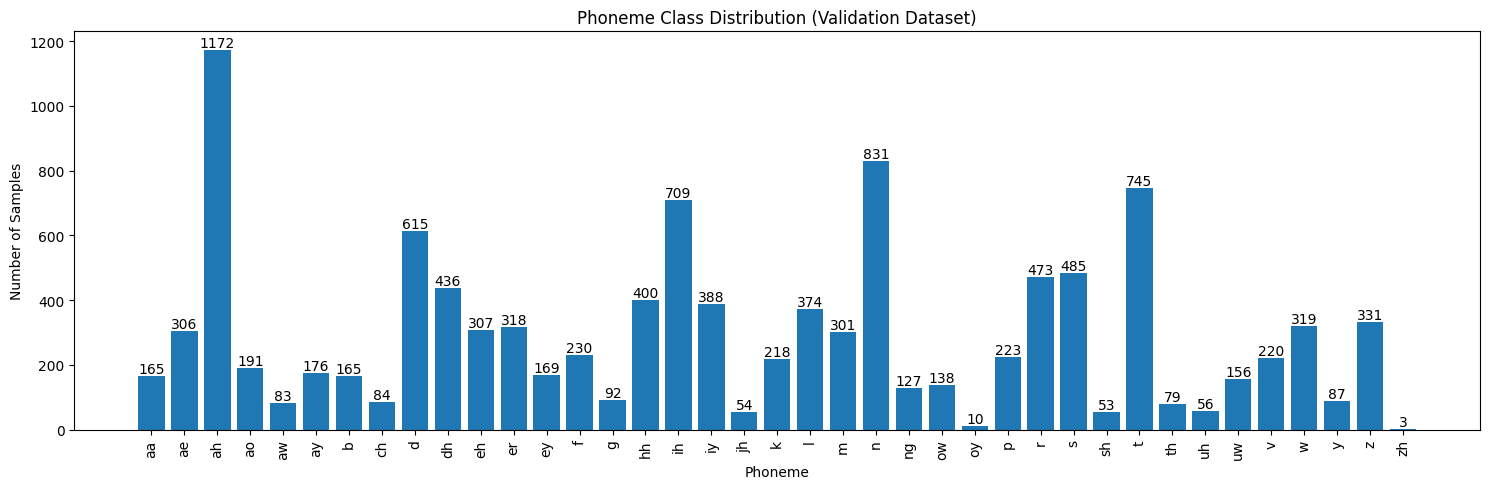

In [47]:
# Validation Dataset
import matplotlib.pyplot as plt
import torch

label_counts = torch.zeros(len(val_dataset.labels_sorted))

for i in range(len(val_dataset)):
    _, label = val_dataset[i]
    label_counts[label] += 1

plt.figure(figsize=(15, 5))
bars = plt.bar(val_dataset.labels_sorted, label_counts.numpy())
plt.xticks(rotation=90)
plt.title("Phoneme Class Distribution (Validation Dataset)")
plt.xlabel("Phoneme")
plt.ylabel("Number of Samples")

# Add the counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment


plt.tight_layout()
plt.show()

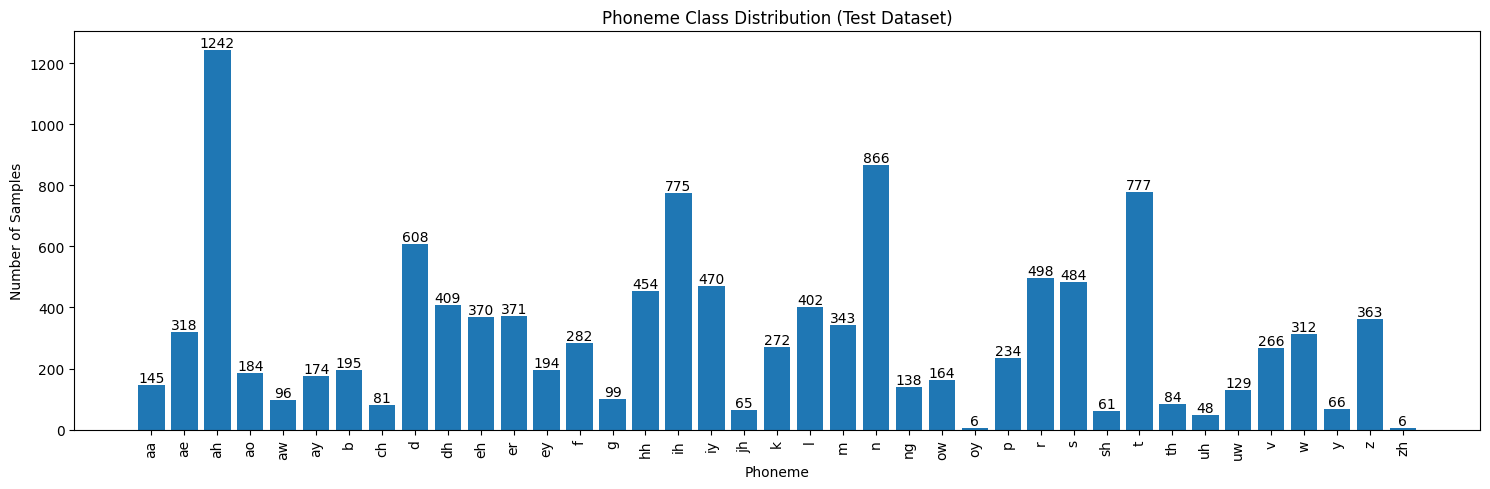

In [46]:
# Test Dataset
import matplotlib.pyplot as plt
import torch

label_counts = torch.zeros(len(test_dataset.labels_sorted))

for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    label_counts[label] += 1

plt.figure(figsize=(15, 5))
bars = plt.bar(test_dataset.labels_sorted, label_counts.numpy())
plt.xticks(rotation=90)
plt.title("Phoneme Class Distribution (Test Dataset)")
plt.xlabel("Phoneme")
plt.ylabel("Number of Samples")

# Add the counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

In [48]:
import sys
from pathlib import Path


from pnpl.datasets import LibriBrainPhoneme

print("Let's look at our train_dataset in more detail:")
print(f"Dataset: {len(train_dataset)} samples")
print(f"Phoneme classes: {len(train_dataset.labels_sorted)}")
print()

# Let's look at one sample
sample_data, label_id = train_dataset[0]
# We can map the label ID to the actual phoneme it represents:
phoneme = train_dataset.id_to_phoneme[label_id.item()]

print(f"SAMPLE 0:")
# Note: The shape of the sample depends on the values you set for tmin and tmax - we're using default values (tmin=0, tmax=0.5)
print(f"  Data shape: {sample_data.shape} (306 MEG channels, by default: 125 samples = 0.5 seconds)")
print(f"  Label ID: {label_id.item()}")
print(f"  Phoneme: '{phoneme}'")
print(f"  Data range: [{sample_data.min():.3f}, {sample_data.max():.3f}]")
print()

# Show phoneme mappings
print(f"PHONEME MAPPINGS:")
for i, phoneme in enumerate(train_dataset.labels_sorted):
    print(f"  ID {i}: '{phoneme}'")

Let's look at our train_dataset in more detail:
Dataset: 93197 samples
Phoneme classes: 39

SAMPLE 0:
  Data shape: torch.Size([306, 125]) (306 MEG channels, by default: 125 samples = 0.5 seconds)
  Label ID: 2
  Phoneme: 'ah'
  Data range: [-1.565, 1.238]

PHONEME MAPPINGS:
  ID 0: 'aa'
  ID 1: 'ae'
  ID 2: 'ah'
  ID 3: 'ao'
  ID 4: 'aw'
  ID 5: 'ay'
  ID 6: 'b'
  ID 7: 'ch'
  ID 8: 'd'
  ID 9: 'dh'
  ID 10: 'eh'
  ID 11: 'er'
  ID 12: 'ey'
  ID 13: 'f'
  ID 14: 'g'
  ID 15: 'hh'
  ID 16: 'ih'
  ID 17: 'iy'
  ID 18: 'jh'
  ID 19: 'k'
  ID 20: 'l'
  ID 21: 'm'
  ID 22: 'n'
  ID 23: 'ng'
  ID 24: 'ow'
  ID 25: 'oy'
  ID 26: 'p'
  ID 27: 'r'
  ID 28: 's'
  ID 29: 'sh'
  ID 30: 't'
  ID 31: 'th'
  ID 32: 'uh'
  ID 33: 'uw'
  ID 34: 'v'
  ID 35: 'w'
  ID 36: 'y'
  ID 37: 'z'
  ID 38: 'zh'


## Important: Signal averaging the training data
While we could now train our model with the above dataloaders, the signal-to-noise ratio of a single sample is not high enough for reliable classifcation.
Therefore, for this years competition, we will only evaluate on samples composed of 100 averaged instances of the same phoneme, with the exception of some of the rarer phonemes, for which less than 100 individual samples were available in the holdout. You can expect the distribution of phonemes in the portion of the holdout relevant for final evaluation to be similar to the validation/test split.

Averaging brain signal with repeated stimuli (usally refered to as "Signal Averaging" or "Event-related potential" in the context of Neuroscience and Electrophysiology) is a common method for improving SNR. Lets explore this method effect on SNR.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

from pnpl.datasets import LibriBrainPhoneme

visualization_dataset = LibriBrainPhoneme(
    data_path=f"{base_path}/data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    include_run_keys=[('0', '1', 'Sherlock1', '1')],
)

# Collect samples for phoneme 'aa'
phoneme_id = visualization_dataset.phoneme_to_id['aa']
samples = []
for i in range(min(len(visualization_dataset), 2000)):
    data, label = visualization_dataset[i]
    if label.item() == phoneme_id and len(samples) < 15:
        samples.append(data)

stacked_samples = torch.stack(samples)
averaged_signal = stacked_samples.mean(dim=0)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
time = np.linspace(0, 0.3, stacked_samples.shape[2])
n_channels_show = 5
n_samples_show = 8

for ch in range(n_channels_show):
    offset = ch * 3
    # Plot multiple individual samples (chaotic)
    for i in range(n_samples_show):
        ax.plot(time, stacked_samples[i, ch, :] + offset, alpha=0.4,
                color='lightblue', linewidth=1)
    # Plot averaged signal (clean)
    ax.plot(time, averaged_signal[ch, :] + offset,
            color='darkred', linewidth=2.5)

ax.set_title('Signal Averaging: Some channels for phoneme /aa/')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Channel')
plt.tight_layout()
plt.show()

As you can see above, averaging the signals of multiple instances of the same phoneme in the training data is sufficient filter out a lot of the noise. This is called [signal averaging](https://en.wikipedia.org/wiki/Signal_averaging). As part of the `pnpl` library, we provide the `GroupedDataset` class to easily  apply this transformation. Let's apply it to our train dataset:

In [ ]:
from pnpl.datasets import GroupedDataset


# Options:
# - `original_dataset`: The original dataset to group
# - `grouped_samples`: How many samples of each phoneme to group (default: 10)
# - `drop_remaining`: Whether to drop the last group if it is incomplete (default: False)
# - `shuffle`: Whether to shuffle the samples (default: False)
# - `average_grouped_samples`: Whether to average the grouped samples (default: True)
averaged_train_dataset = GroupedDataset(train_dataset, grouped_samples = 100)

# As expected, averaging 100 phonemes into a single sample (while keeping the incomplete final groups) reduces the total number of samples by just under 100x:
print("Single samples: ", len(train_dataset))
print("Averaged samples: ", len(averaged_train_dataset))

Keep in mind that while we will evaluate the results on averging of 100 instances, we invite participants to find the optimal value for training a phoneme model. We will stick with grouping 100 samples in this notebook, but you may wish to try other options!

## Defining the model
Now that we have explored the training data in detail, this is the model architecture we'll use:

In [ ]:
import torch
import lightning as L
from torch import nn
from torchmetrics import F1Score

# Basic LightningModule
class PhonemeClassificationModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(306, 128, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16000, 39)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.f1_macro = F1Score(num_classes=39, average='macro', task="multiclass")
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        f1_macro = self.f1_macro(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_f1_macro', f1_macro)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        f1_macro = self.f1_macro(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_f1_macro', f1_macro, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0005)

## Actually training
The code below will train the model.

In [ ]:
import os
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

# Setup paths for logs and checkpoints
LOG_DIR = f"{base_path}/lightning_logs"
CHECKPOINT_PATH = f"{base_path}/models/phoneme_model.ckpt"

# Minimal logging setup
logger = CSVLogger(
    save_dir=LOG_DIR,
    name="",
    version=None,
)
if in_colab:  # In Colab, we use the built-in Tensorboard setup
    logger = TensorBoardLogger(
        save_dir=LOG_DIR,
        name="",
        version=None,
        default_hp_metric=True
    )
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    %load_ext tensorboard
    %tensorboard --logdir $LOG_DIR

# Set a fixed seed for reproducibility
L.seed_everything(42)

# Conditionally set num_workers to avoid multiprocessing issues (try increasing if performance is problematic)
num_workers = 2 if in_colab else 0

# Configure data loaders
train_dataloader = DataLoader(averaged_train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

# Initialize the PhonemeClassificationModel model
model = PhonemeClassificationModel()

# Log Hyperparameters (these will be empty be default!)
logger.log_hyperparams(model.hparams)

# Initialize trainer
trainer = L.Trainer(
    devices="auto",
    max_epochs=15,
    logger=logger,
    enable_checkpointing=True,
)

# Actually train the model
trainer.fit(model, train_dataloader, val_dataloader)

# Save the trained model
trainer.save_checkpoint(CHECKPOINT_PATH)

## Validating our results
Let's look at how our model performs.

In [ ]:
from torchmetrics import F1Score

def validate(val_loader, module, labels):
    disp_labels = labels
    module.eval()
    predicted_phonemes = []
    true_phonemes = []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x = x.to(module.device)
            y = y.to(module.device)
            outputs = module(x)
            preds = torch.argmax(outputs, dim=1)
            predicted_phonemes.extend(preds)
            true_phonemes.extend(y)

    true_phonemes = torch.stack(true_phonemes)
    predicted_phonemes = torch.stack(predicted_phonemes)

    f1_macro = F1Score(task="multiclass", average="macro",
                       num_classes=len(disp_labels)).to(module.device)

    random_preds = torch.randint(
        0, len(disp_labels), (len(true_phonemes),), device=module.device)

    random_f1_macro = f1_macro(
        random_preds, true_phonemes)

    f1_macro = f1_macro(predicted_phonemes, true_phonemes)


    binary_f1 = F1Score(task="binary").to(module.device)

    classes = torch.arange(len(disp_labels))
    f1_by_class = []
    random_f1_by_class = []
    for c in classes:
        class_preds = predicted_phonemes == c
        class_targets = true_phonemes == c
        class_f1 = binary_f1(class_preds, class_targets)
        class_random_preds = random_preds == c
        class_random_f1 = binary_f1(class_random_preds, class_targets)

        f1_by_class.append(class_f1)
        random_f1_by_class.append(class_random_f1)

    # We want to return tensors not lists
    f1_by_class = torch.stack(f1_by_class)
    random_f1_by_class = torch.stack(random_f1_by_class)

    return f1_macro, random_f1_macro, f1_by_class, random_f1_by_class

In [ ]:
f1_macro, random_f1_macro, f1_by_class, random_f1_by_class = validate(val_dataloader, model, val_dataset.labels_sorted)
print("F1 Macro for random predictions (1/39): ", random_f1_macro)
print("F1 Macro for model predictions: ", f1_macro)

In [ ]:
from matplotlib import pyplot as plt

plt.bar(x=(0,1), height=(f1_macro.item(), random_f1_macro.item()), tick_label=("Model", "Random"), color=("salmon", "skyblue"))
plt.title("F1 Macro")
plt.show()

Great! We were able to achieve better-than-chance results in terms of F1-Macro and Balanced Accuracy! Let's look at the results for individual classes and see which phonemes we were able to perform well on.

In [ ]:
import numpy as np

def plot_class_specific_scores(scores, random_scores, metric_name, labels, sort=True):

    num_classes = len(labels)


    # If sorting is requested, reorder the bars based on the criteria.
    if sort:
        order = torch.argsort(scores).flip(dims=[0])
    else:
        order = torch.arange(len(scores))

    # Reorder the arrays along the class dimension (axis=1) and update the summary statistics
    scores = scores[order]
    random_scores = random_scores[order]
    labels = [labels[i] for i in order]
    # Positions of the groups on the x-axis
    x = np.arange(num_classes)

    # Width of each bar
    width = 0.35

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(25, 12))

    # Plot Random scores bars
    bars1 = ax.bar(x - width/2, random_scores, width,
                label='Random', capsize=5, color='skyblue', edgecolor='black')

    # Plot Actual score bars
    bars2 = ax.bar(x + width/2, scores, width,
                label='Model', capsize=5, color='salmon', edgecolor='black')

    # Add labels and title
    ax.set_xlabel('Phonemes', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_title(metric_name + " for each Phoneme", fontsize=20)

    # Set x-axis tick labels
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=16)

    # Add legend
    ax.legend(fontsize=14)

    # Add grid for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Display the plot
    plt.show()

In [ ]:
plot_class_specific_scores(scores=f1_by_class, random_scores=random_f1_by_class, metric_name="F1", labels=val_dataset.labels_sorted)

## That's it! 🥳
You've successfully trained a model that significantly outperforms random guessing in phoneme classification from MEG data - congrats! Thanks for taking the time to look at and/or participate in our competition. If you have any open questions, get in touch on [our Discord server](https://neural-processing-lab.github.io/2025-libribrain-competition/links/discord)!
Once you're ready to get your score on the leaderboard, take a look at the [submission tutorial](https://neural-processing-lab.github.io/2025-libribrain-competition/links/submission-colab). You might also want to take another look at the [competition website](https://neural-processing-lab.github.io/2025-libribrain-competition).

In [31]:
print(label_counts.dtype)

torch.float32
